Finish training and validate on test data (print confusion matrix and report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import load

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
#dataset is available https://drive.google.com/drive/folders/1WJemKpDspMnvEU_4oyxkxAxgvVihuKr5?usp=sharing
#you can

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
import os

In [ ]:
directory = '/content/drive/MyDrive/Colab_Notebooks/NA_Fish_Dataset/NA_Fish_Dataset'
clases = os.listdir(directory)

In [ ]:
clases

['Striped Red Mullet',
 'Red Mullet',
 'Black Sea Sprat',
 'Trout',
 'Red Sea Bream',
 'Sea Bass',
 'Gilt Head Bream',
 'Shrimp',
 'Horse Mackerel']

In [ ]:
clases = clases[:3]

In [ ]:
clases

['Striped Red Mullet', 'Red Mullet', 'Black Sea Sprat']

In [ ]:
directory = '/content/drive/MyDrive/Colab_Notebooks/NA_Fish_Dataset/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases:
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [ ]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/Colab_Notebooks/NA_Fish...,Striped Red Mullet
1,/content/drive/MyDrive/Colab_Notebooks/NA_Fish...,Striped Red Mullet
2,/content/drive/MyDrive/Colab_Notebooks/NA_Fish...,Striped Red Mullet
3,/content/drive/MyDrive/Colab_Notebooks/NA_Fish...,Striped Red Mullet
4,/content/drive/MyDrive/Colab_Notebooks/NA_Fish...,Striped Red Mullet


In [ ]:
len(df)

150

In [ ]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 150/150 [03:05<00:00,  1.24s/it]


In [ ]:
torch.cuda.is_available()

True

In [ ]:
df.head()

,img,target
0,"[[[113, 89, 69], [120, 93, 68], [115, 94, 66],...",Striped Red Mullet
1,"[[[129, 108, 60], [126, 108, 62], [129, 110, 6...",Striped Red Mullet
2,"[[[128, 103, 68], [135, 106, 75], [136, 112, 8...",Striped Red Mullet
3,"[[[104, 108, 87], [107, 82, 50], [107, 113, 12...",Striped Red Mullet
4,"[[[131, 108, 67], [136, 111, 85], [139, 109, 7...",Striped Red Mullet


In [ ]:
df['target'].unique()

array(['Striped Red Mullet', 'Red Mullet', 'Black Sea Sprat'],
      dtype=object)

In [ ]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [ ]:
df.head()

,img,target
0,"[[[113, 89, 69], [120, 93, 68], [115, 94, 66],...",Striped Red Mullet
1,"[[[129, 108, 60], [126, 108, 62], [129, 110, 6...",Striped Red Mullet
2,"[[[128, 103, 68], [135, 106, 75], [136, 112, 8...",Striped Red Mullet
3,"[[[104, 108, 87], [107, 82, 50], [107, 113, 12...",Striped Red Mullet
4,"[[[131, 108, 67], [136, 111, 85], [139, 109, 7...",Striped Red Mullet


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [ ]:
len(y_train)

120

In [ ]:
len(y_test)

30

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [ ]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print("slkdjflksdjflksjdflkj", x.shape)
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
if torch.cuda.is_available():
  net = MyConvNet().cuda()
else:
  net = MyConvNet()

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

#net.forward(torch.FloatTensor(batch[0]))

torch.Size([4, 3, 256, 256])


In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NameError: name 'torch' is not defined

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.9727148294448853  test_loss  1.4882009625434875
epoch  1  train_loss  1.1791662494341533  test_loss  1.0585269778966904
epoch  2  train_loss  1.0128334701061248  test_loss  1.0030681937932968
epoch  3  train_loss  0.9142354190349579  test_loss  0.935802735388279
epoch  4  train_loss  0.8252785394589106  test_loss  0.8783567100763321
epoch  5  train_loss  0.7423590083916982  test_loss  0.8266718909144402
epoch  6  train_loss  0.6589261064926784  test_loss  0.7726005464792252
epoch  7  train_loss  0.5762145340442657  test_loss  0.7037295773625374
epoch  8  train_loss  0.49013247191905973  test_loss  0.6480293720960617
epoch  9  train_loss  0.42438579921921094  test_loss  0.5984755977988243


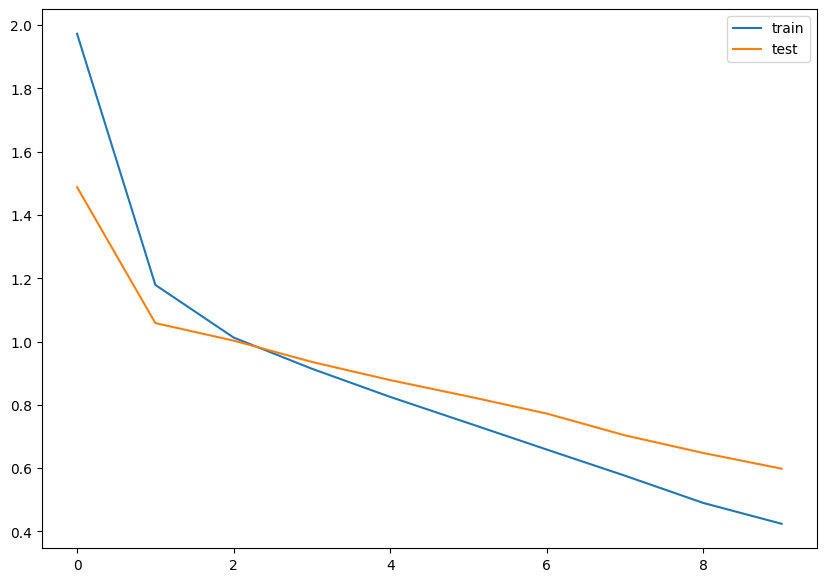

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [ ]:
y_pred = []
#Test your model on X_test data and show confusion_matrix and classification_report
y_true = []

with torch.no_grad():
    for batch in testloader:
        X_test_batch, y_test_batch = batch
        X_test_batch = X_test_batch.to(device, dtype=torch.float32)

        outputs = net(X_test_batch)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_test_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

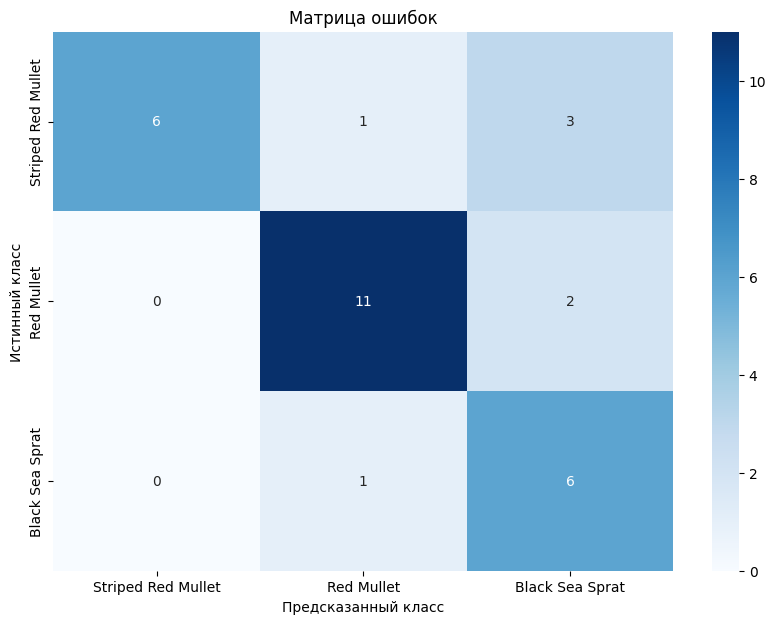

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns



plt.figure(figsize=(10,7))
conf_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()


In [ ]:
y_pred[:5]
print(classification_report(y_true, y_pred, target_names=clases))


                    precision    recall  f1-score   support

Striped Red Mullet       1.00      0.60      0.75        10
        Red Mullet       0.85      0.85      0.85        13
   Black Sea Sprat       0.55      0.86      0.67         7

          accuracy                           0.77        30
         macro avg       0.80      0.77      0.75        30
      weighted avg       0.83      0.77      0.77        30



In [ ]:
#from sklearn.metrics import confusion_matrix
#print(confusion_matrix(test, pred))
#from sklearn.metrics import classification_report
#print(classification_report(test, pred))

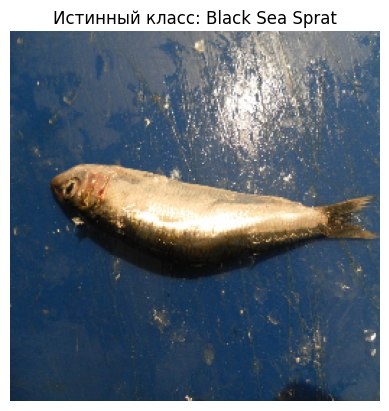

Предсказанный класс: Black Sea Sprat


In [ ]:
#Add the block of code which will predict the value of one image

import random

idx = random.randint(0, len(X_test) - 1)

image = X_test[idx]
true_label = y_test[idx]

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Истинный класс: {clases[true_label]}")
plt.show()



transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)

net.eval()
with torch.no_grad():
    output = net(image_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_label = predicted_class.item()
print(f"Предсказанный класс: {clases[predicted_label]}")
